In [3]:
import torch
import os
import numpy as np
import pandas as pd
import re
import nltk
import unidecode
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

nltk.download('stopwords')


seed = 1
torch.manual_seed(seed)




[nltk_data] Downloading package stopwords to /home/tan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
dataset_path = 'dataset/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(dataset_path, names=headers, encoding='ISO-8859-1')
df.head()


,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
classes = {class_name: idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])


In [6]:
df.head()

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


### Tiền xử lí dữ liệu
- Để tận dùng hàm apply của pandas, ta sẽ tiền xử lý văn bản cột content ngay tại đây. Đầu tiên, định nghĩa hàm chuẩn hóa, nhận tham số đầu vào là 1 text và trả về 1 text đã được chuẩn hóa:

In [7]:
english_stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer() 
def text_normalize(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in stopwords.words('english')])
    text = ' '.join([PorterStemmer().stem(word) for word in text.split(' ')])
    
    return text


- Các kỹ thuật chuẩn hóa được áp dụng trong bài bao gồm: Chuyển chữ viết thường (Lowercas-
ing), Xóa dấu câu (Punctuation Removal), Xóa stopwords (Stopwords Removal), Stemming.

Sau đó, áp dụng hàm text_normalize() vào cột content:

In [8]:
df['content'] = df['content'].apply(lambda x: text_normalize(x))

### Xây dựng bộ từ vựng
- Để huấn luyện dữ liệu văn bản, ta cần chuyển đổi các văn bản
thành vector. Phương thức đơn giản nhất, ta sẽ thu thập toàn bộ các từ trong bộ dữ liệu
thành một tập từ vựng, mỗi từ có một ID riêng. Từ đó, với một văn bản đầu, ta quy đổi
sang ID tương ứng, như vậy sẽ được một vector số nguyên. Đoạn code tạo bộ từ vựng được
thực hiện như sau:

In [9]:
vocab = []
for sentence in df['content'].tolist():
    tokens = sentence.split(' ')
    for token in tokens:
        if token not in vocab:
            vocab.append(token)

vocab.append('<UNK>')
vocab.append('<PAD>')
word_to_idx = { word : idx for idx , word in enumerate ( vocab ) }
vocab_size = len( vocab )

- Với bộ từ vựng trên, ta xây dựng hàm transform() dùng để chuyển đổi văn bản thành danh
sách các số nguyên như sau:

In [10]:
def transform(text, word_to_index, max_seq_length):
    tokens = []
    for w in text.split(' '):
        try:
            w_ids = word_to_index[w]
        except:
            w_ids = word_to_index['<UNK>']
        tokens.append(w_ids)

    if len(tokens) < max_seq_length:
        tokens += [word_to_index['<PAD>']] * (max_seq_length - len(tokens))
    elif len(tokens) > max_seq_length:
        tokens = tokens[:max_seq_length]

    return tokens    


#### Chia bộ dữ liệu train, val, test: 
- Ta dùng hàm train_test_split của thư viện scikit-learn
để chia bộ dữ liệu thành 3 bộ train/val/test theo tỷ lệ 7:2:1:

In [11]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

### Xây dựng Pytorch dataset:
- Ta triển khai class tên FinancialNews với đầu vào gồm cặp
dữ liệu đầu vào X - y, bộ từ điển cũng như hàm transform như sau:

In [12]:
class FinancialNews(Dataset):
    def __init__(self, X, y, word_to_idx, max_seq_len, transform=None):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.transform:
            text = self.transform(text, self.word_to_idx, self.max_seq_len)

        text = torch.tensor(text)

        return text, label


### Khai báo dataloader:

In [34]:
max_seq_len = 32

train_dataset = FinancialNews(X_train, y_train, word_to_idx=word_to_idx, max_seq_len=max_seq_len, transform=transform)
val_dataset = FinancialNews(X_val, y_val, word_to_idx=word_to_idx, max_seq_len=max_seq_len, transform=transform)
test_dataset = FinancialNews(X_test, y_test, word_to_idx=word_to_idx, max_seq_len=max_seq_len, transform=transform)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)


### Xây dựng mô hình

In [35]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, n_layers, n_classes, dropout_prob):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.fc2 = nn.Linear(16, n_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.embedding(x)
        x, hn = self.rnn(x)
        x = x[:,-1,:]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        out = self.fc2(x)
        return out

In [36]:
n_classes = len(classes.keys())
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_size=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
).to(device)

### Cài đặt Loss và Optimizer

In [37]:
lr = 1e-4
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


### Thực hiện huấn luyện 

In [38]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        batch_train_losses = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}")

    return train_losses, val_losses

def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    loss = sum(losses) / len(losses)
    acc = correct / total
    
    return loss, acc


In [40]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 0.6919	Val loss: 0.9447
EPOCH 2:	Train loss: 0.6929	Val loss: 0.9505
EPOCH 3:	Train loss: 0.6860	Val loss: 0.9456
EPOCH 4:	Train loss: 0.6935	Val loss: 0.9509
EPOCH 5:	Train loss: 0.6819	Val loss: 0.9683
EPOCH 6:	Train loss: 0.6798	Val loss: 0.9636
EPOCH 7:	Train loss: 0.6780	Val loss: 0.9505
EPOCH 8:	Train loss: 0.7176	Val loss: 0.9476
EPOCH 9:	Train loss: 0.6809	Val loss: 0.9621
EPOCH 10:	Train loss: 0.6725	Val loss: 0.9703
EPOCH 11:	Train loss: 0.6841	Val loss: 0.9581
EPOCH 12:	Train loss: 0.6698	Val loss: 0.9565
EPOCH 13:	Train loss: 0.6770	Val loss: 0.9662
EPOCH 14:	Train loss: 0.6663	Val loss: 0.9769
EPOCH 15:	Train loss: 0.6622	Val loss: 0.9646
EPOCH 16:	Train loss: 0.6604	Val loss: 0.9731
EPOCH 17:	Train loss: 0.6489	Val loss: 0.9830
EPOCH 18:	Train loss: 0.6492	Val loss: 0.9927
EPOCH 19:	Train loss: 0.6524	Val loss: 0.9815
EPOCH 20:	Train loss: 0.6500	Val loss: 0.9866
EPOCH 21:	Train loss: 0.6504	Val loss: 0.9823
EPOCH 22:	Train loss: 0.6479	Val loss: 0.99

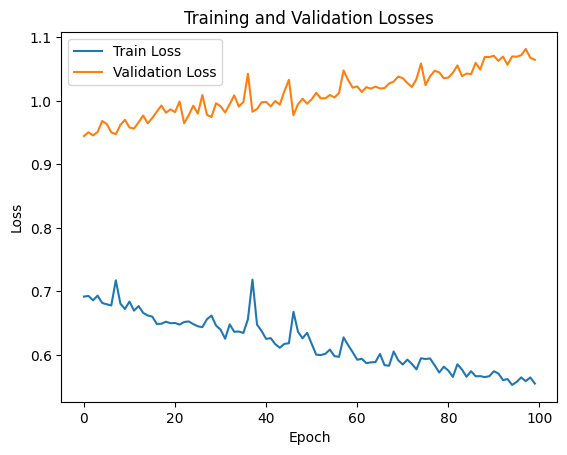

In [41]:
import matplotlib.pyplot as plt

# Plotting train_losses and val_losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [30]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print('Evaluation on val / test dataset')
print('Val accuracy:', val_acc)
print('Test accuracy:', test_acc)

Evaluation on val / test dataset
Val accuracy: 0.5257731958762887
Test accuracy: 0.5180412371134021
